In [40]:
import numpy as np
import pandas as pd
import random, copy, os
random.seed(42)
np.random.seed(42)
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from multiprocessing import Pool
import multiprocessing
%run helper.ipynb
%run algorithm_functions.ipynb

In [41]:
size_v, size_u, T, driver_quota = 100, 100, 700, 2
average_arrival_rate = T/size_v
filename_append = 'quota_{}'.format(driver_quota)
average_arrival_rate

7.0

In [42]:
drivers, requests = [], []
for i in range(size_u):
    drivers.append(Driver(d_id=i, driver_race='NA', driver_gender='NA', pickup_lat_bin='NA', 
                          pickup_long_bin='NA', quota=driver_quota))
    
arrival_probabilities = np.random.random(size=size_v)
arrival_probabilities /= np.sum(arrival_probabilities)

for i in range(size_v):
    requests.append(Request(pickup_lat_bin=i, pickup_long_bin=i, dropoff_lat_bin=i, 
                            dropoff_long_bin=i, requests_gender=i, requests_race=i, 
                            arrival_rate=int(round(arrival_probabilities[i] * T)), # r_v is randomly chosen from a normal distribution
                            distance=np.random.random())) # w_f is a random value between 0 and 1
set_unique_ids(drivers)
set_unique_ids(requests)

In [43]:
def filter_requests(requests):
    new_requests = []
    for r in requests:
        if r.arrival_rate >= 5:
            new_requests.append(r)
    return new_requests

In [44]:
requests = filter_requests(requests)
set_unique_ids(requests)
T = int(np.sum([r.arrival_rate for r in requests]))
size_v, size_u = len(requests), len(drivers)
T, size_v, size_u

(630, 66, 100)

In [45]:
probability_matrix = np.full((size_u, size_v), -1, dtype=float) # drivers x requests
profit_matrix = np.zeros((size_u, size_v), dtype=float)

In [46]:
for i in range(size_u):
    for j in range(size_v):
        # An edge exists with probability of 0.1 and not with a probability of 0.9
        edge_exists = np.random.choice([True, False], size=1, p=[0.1, 0.9])
        if edge_exists[0]:
            probability_matrix[i, j] = np.random.random() # randomly assign probability
            profit_matrix[i, j] = requests[j].distance

In [47]:
for i in range(probability_matrix.shape[1]):
    assert np.count_nonzero(probability_matrix[:,i] != -1) > 0
for i in range(probability_matrix.shape[0]):
    assert np.count_nonzero(probability_matrix[i,:] != -1) > 0

In [48]:
r_vs = []
for r in requests:
    r_vs.append(r.arrival_rate)
min(r_vs), max(r_vs)

in_degree_v = []
for i in range(len(requests)):
    in_degree_v.append(np.count_nonzero(probability_matrix[:,i] != -1))

in_degree_u = []
for i in range(len(drivers)):
    in_degree_u.append(np.count_nonzero(probability_matrix[i,:] != -1))

print ("Drivers' in-degree, average: {}, min: {}, max: {}\nRiders' in-degree, average: {}, min: {}, max: {}"\
       .format(np.mean(in_degree_u), min(in_degree_u), max(in_degree_u), 
               np.mean(in_degree_v), min(in_degree_v), max(in_degree_v)))

Drivers' in-degree, average: 6.85, min: 1, max: 13
Riders' in-degree, average: 10.378787878787879, min: 2, max: 22


In [49]:
print ("Drivers (|U|): {}, Requests (T): {}, Request Types (|V|): {}".format(len(drivers), 
                                                                       calculate_T(requests), len(requests)))

Drivers (|U|): 100, Requests (T): 630, Request Types (|V|): 66


In [50]:
from cvxopt.base import matrix as m
from cvxopt import solvers
from cvxopt.modeling import op, dot, variable, max, min

In [51]:
x_f = variable(np.count_nonzero(probability_matrix != -1))
profit, c = get_profit_objective(x_f, probability_matrix, profit_matrix)

In [52]:
x_fair = variable(np.count_nonzero(probability_matrix != -1))
fairness = get_fairness_objective(x_fair, probability_matrix, requests)

In [53]:
def get_inequalities_local(x_f, probability_matrix, requests, return_coefficients=False):
    offset = 0
    A, b = [], [] # model all inequalities as A * x <= b
    # models the inequalities 3 and 4 in the writeup
    for i in range(probability_matrix.shape[0]): # iterate over all drivers
        a1, a2 = [0] * len(x_f), [0] * len(x_f) # coefficients of inequalities
        edges_count = np.count_nonzero(probability_matrix[i] != -1)
        edges_probabilities = probability_matrix[i][np.where(probability_matrix[i] != -1)]
        assert len(edges_probabilities) == edges_count # sanity check
        a1[offset:offset + edges_count] = edges_probabilities
        a2[offset:offset + edges_count] = [1] * edges_count
        A.append(a1)
        A.append(a2)
        b.append(1.0)
        b.append(drivers[i].quota)
        offset += edges_count
    # Models the inequality -1 * x_f <= 0 for all edges
    for i in range(len(x_f)):
        a1 = [0] * len(x_f)
        a1[i] = -1
        A.append(a1)
        b.append(0.0)
    # Models inequality 5 in the writeup
    for j in range(probability_matrix.shape[1]):# iterate over all request types
        # j -> request; i-> driver
        a1 = [0] * len(x_f)
        for i in np.where(probability_matrix[:,j] != -1)[0]:
            a1[coordinate_to_index(i, j, probability_matrix)] = 1
        A.append(a1)
        b.append(requests[j].arrival_rate)
    print (len(A), len(b), len(A[0]), len(x_f))
    
    A, b = m(A).T, m(np.array(b))

    if not return_coefficients:
        inequality = (A * x_f <= b)
        return inequality
    else:
        return A, b

In [54]:
inequality = get_inequalities_local(x_f, probability_matrix, requests)

951 951 685 685


In [55]:
lp_profit = op(profit, inequality)
lp_profit.solve(solver='glpk')

In [56]:
max(x_f.value), min(x_f.value)

(2.0, -4.977431652073186e-16)

In [57]:
inequality_fairness = get_inequalities_local(x_fair, probability_matrix, requests)

951 951 685 685


In [58]:
lp_fairness = op(fairness, inequality_fairness)
lp_fairness.solve(solver='glpk')

In [59]:
optimal_profit = -1 * lp_profit.objective.value()[0]
optimal_fairness = -1 * lp_fairness.objective.value()[0]
print ("When optimizing for fairness, fairness: {}, profit: {}".format(optimal_fairness, 
                                                                      -1 * dot(c, x_fair).value()[0]))
print ("When optimizing for profit, fairness: {}, profit: {}".format(
    -1 * get_fairness_objective(x_f, probability_matrix, requests).value()[0], optimal_profit))

When optimizing for fairness, fairness: 0.1308656817244893, profit: 40.451634373205096
When optimizing for profit, fairness: -1.0527172603331295e-17, profit: 77.4364812913856


In [60]:
lp_solution_sanity_check(x_f, x_fair, probability_matrix, requests)

In [61]:
alphas, betas = np.arange(0.,1.01,0.1), np.arange(0.,1.01,0.1)
num_loops = 5000

In [62]:
all_requests = []
for r in requests:
    all_requests += [r] * int(r.arrival_rate)
random.shuffle(all_requests)

In [ ]:
matching_results = get_matching_results(all_requests, drivers, probability_matrix, 
                                            x_f, x_fair, alphas, num_loops)

In [ ]:
edges_count_results = get_edges_count_results(all_requests, matching_results, requests)

In [77]:
profit_crs, fairness_crs = get_profit_fairness_crs(matching_results, edges_count_results, num_loops, requests, 
                        alphas, optimal_profit, optimal_fairness)

0.59507065850344 0.3246076392238026
0.5984609726146506 0.2949589188803856
0.603113973534791 0.30137771400627994
0.6075506287077186 0.35996979259136735
0.6100344993548538 0.33530563110029327
0.6151522496574193 0.34967150590586643
0.6182058027468263 0.34598011090672565
0.6219537380223016 0.3411601365447903
0.6232695195353338 0.34421670565235907
0.6286025715009358 0.3370455242846016
0.6301555185791304 0.3158846612322025


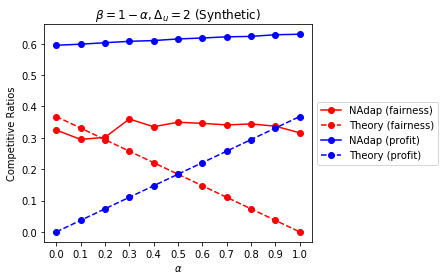

In [78]:
plot_lines([fairness_crs, [x/np.e for x in 1-alphas], profit_crs, [x/np.e for x in alphas]], 
            ["{:.1f}".format(x) for x in alphas], alphas, 
           r'$\beta = 1 - \alpha, \Delta_u = {}$ (Synthetic)'.format(driver_quota), 
           r'$\alpha$', 'Competitive Ratios', ['-', '--', '-', '--'], ['red', 'red', 'blue', 'blue'], 
            ['NAdap (fairness)', 'Theory (fairness)', 'NAdap (profit)', 'Theory (profit)'], 
            'plots', 'profit_fairness_crs_vs_alpha_synthetic_{}'.format(filename_append))

## Uniform and Greedy algorithms

In [ ]:
uniform_params, greedy_params = [], []
for i in range(num_loops):
    drivers_copy = [copy.deepcopy(d) for d in drivers]
    uniform_params.append([all_requests, drivers_copy, probability_matrix])
for i in range(num_loops):
    drivers_copy = [copy.deepcopy(d) for d in drivers]
    greedy_params.append([all_requests, drivers_copy, probability_matrix])

In [ ]:
with Pool(multiprocessing.cpu_count()) as p:
    uniform_results = p.starmap(run_uniform, uniform_params)

In [ ]:
with Pool(multiprocessing.cpu_count()) as p:
    greedy_results = p.starmap(run_greedy, greedy_params)

In [ ]:
greedy_profit = 0
for res in greedy_results:
    greedy_profit += res[1]
greedy_profit /= num_loops
greedy_profit_cr = greedy_profit/optimal_profit
greedy_profit_cr

In [ ]:
greedy_fairness_measure_params = []
for i in range(num_loops):
    greedy_fairness_measure_params.append([all_requests, greedy_results[i][0], requests])

with Pool(multiprocessing.cpu_count()) as p:
    greedy_edges_count_results = p.starmap(measure_fairness_edges_count, greedy_fairness_measure_params)

In [ ]:
greedy_fairness_cr = calculate_fairness_from_array(greedy_edges_count_results, 
                                                   num_loops, requests)/optimal_fairness
greedy_fairness_cr

In [ ]:
uniform_profit = 0
for res in uniform_results:
    uniform_profit += res[1]
uniform_profit /= num_loops
uniform_profit_cr = uniform_profit/optimal_profit
uniform_profit_cr

In [ ]:
uniform_fairness_measure_params = []
for i in range(num_loops):
    uniform_fairness_measure_params.append([all_requests, uniform_results[i][0], requests])

with Pool(multiprocessing.cpu_count()) as p:
    uniform_edges_count_results = p.starmap(measure_fairness_edges_count, uniform_fairness_measure_params)

In [ ]:
uniform_fairness_cr = calculate_fairness_from_array(uniform_edges_count_results, 
                                                    num_loops, requests)/optimal_fairness
uniform_fairness_cr

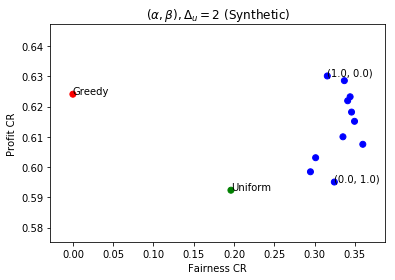

In [79]:
x_vals = fairness_crs + [uniform_fairness_cr, greedy_fairness_cr]
y_vals = profit_crs + [uniform_profit_cr, greedy_profit_cr]
annotations = ['({:.1f}, {:.1f})'.format(alpha, 1-alpha) if alpha == 1.0 or alpha == 0.0 else '' for alpha in alphas] + ['Uniform', 'Greedy']
colors = ['blue'] * len(fairness_crs) + ['green', 'red']
plot_scatter(x_vals, y_vals, colors, annotations, 
             r'$(\alpha, \beta), \Delta_u = {}$ (Synthetic)'.format(driver_quota), 'Fairness CR', 'Profit CR', 
             'plots', 'fairness_vs_profit_cr_scatter_synthetic_{}'.format(filename_append))

### For all other alpha, beta where alpha + beta < 1

In [40]:
remaining_algorithm_params = []
coordinate_to_offset = {}
offset = 0
for alpha_i in range(len(alphas)):
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            coordinate_to_offset[(alpha_i, beta_j)] = offset
            offset += 1
            for i in range(num_loops):
                remaining_algorithm_params.append([all_requests, [copy.deepcopy(d) for d in drivers],
                                                   probability_matrix, x_f, x_fair, 
                                                   alphas[alpha_i], betas[beta_j]])

In [41]:
with Pool(multiprocessing.cpu_count()) as p:
    remaining_matching_results = p.starmap(run_algorithm, remaining_algorithm_params)

In [45]:
remaining_fairness_measure_params = []
for alpha_i in range(len(alphas)):
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            for i in range(num_loops):
                remaining_fairness_measure_params.append([all_requests, 
                            remaining_matching_results[coordinate_to_offset[(alpha_i, beta_j)] + i][2], requests])

In [46]:
with Pool(multiprocessing.cpu_count()) as p:
    remaining_edges_count_results = p.starmap(measure_fairness_edges_count, remaining_fairness_measure_params)

In [47]:
expected_fairness_map, expected_profit_map = np.full((len(alphas), len(betas)), np.nan), \
                                                np.full((len(alphas), len(betas)), np.nan)
for alpha_i in range(len(alphas)):
    for beta_j in range(len(betas)):
        if alphas[alpha_i] + betas[beta_j] <= 1:
            offset_index = coordinate_to_offset[(alpha_i, beta_j)]
            assert offset_index*num_loops <= len(remaining_edges_count_results) - num_loops
            
            remaining_fairness_counts = remaining_edges_count_results[offset_index * num_loops:(offset_index+1)*num_loops]
            print ((np.sum(remaining_fairness_counts, axis=0)/num_loops))
            expected_fairness_map[len(alphas) - alpha_i - 1, beta_j] = \
                calculate_fairness_from_array(remaining_fairness_counts, num_loops, requests)/optimal_fairness
            expected_profit = 0
            for i in range(num_loops):
                expected_profit += remaining_matching_results[offset_index + i][0]
            expected_profit /= num_loops
            expected_profit_map[len(alphas) - alpha_i - 1, beta_j] = expected_profit/optimal_profit
#         elif alphas[alpha_i] + betas[beta_j] == 1:
#             expected_fairness_map[len(alphas) - alpha_i - 1, beta_j] = fairness_crs[alpha_i]
#             expected_profit_map[len(alphas) - alpha_i - 1, beta_j] = profit_crs[alpha_i]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.0002 0.0002 0.0001 0.     0.0002 0.0001 0.0001 0.     0.0001 0.0001
 0.0001 0.     0.     0.     0.     0.     0.     0.     0.0001 0.
 0.     0.0001 0.     0.     0.0001 0.     0.0001 0.     0.0001 0.
 0.     0.0001 0.     0.     0.0001 0.0001 0.0001 0.     0.0001 0.
 0.     0.0001 0.0002 0.     0.     0.     0.     0.     0.     0.0001
 0.     0.0001 0.0001 0.     0.     0.     0.     0.0001 0.0002 0.
 0.     0.0001 0.0001 0.0001 0.0001 0.     0.0001 0.     0.0002 0.
 0.     0.    ]
[0.0002 0.0004 0.0001 0.     0.0003 0.0002 0.0001 0.     0.0003 0.0002
 0.0002 0.0001 0.     0.     0.     0.     0.     0.0002 0.0002 0.
 0.     0.0003 0.0003 0.0001 0.0003 0.0001 0.0001 0.0001 0.0002 0.
 0.     0.0002 0.0001 0.0001 0.0001 0.0002 0.0001 0.0001 0.0003 0.
 0.0001 0.0002 

[0.0004 0.0018 0.0019 0.0013 0.0012 0.0013 0.001  0.0017 0.0017 0.0007
 0.0012 0.0007 0.0003 0.0002 0.0009 0.0004 0.0007 0.0007 0.0012 0.0003
 0.0005 0.0014 0.0022 0.0018 0.0022 0.0007 0.0009 0.0008 0.001  0.0016
 0.0002 0.001  0.001  0.0009 0.0012 0.0017 0.0013 0.0019 0.0017 0.0014
 0.0018 0.0011 0.0011 0.0004 0.002  0.0006 0.0004 0.001  0.0015 0.0016
 0.0009 0.0009 0.0011 0.0016 0.0012 0.0006 0.0015 0.0014 0.0006 0.0008
 0.0004 0.001  0.0013 0.0019 0.0009 0.001  0.0015 0.0008 0.0014 0.0011
 0.0007 0.0006]
[0.0005 0.0021 0.002  0.0013 0.0012 0.0014 0.001  0.0017 0.0021 0.0008
 0.0013 0.0008 0.0003 0.0002 0.0009 0.0004 0.0008 0.0008 0.0012 0.0003
 0.0005 0.0016 0.0022 0.0018 0.0023 0.0007 0.001  0.0008 0.001  0.0017
 0.0002 0.0011 0.001  0.001  0.0012 0.0017 0.0014 0.0019 0.0017 0.0014
 0.0019 0.0011 0.0011 0.0004 0.002  0.0006 0.0004 0.001  0.0015 0.0017
 0.001  0.0011 0.0013 0.0016 0.0013 0.0007 0.0016 0.0015 0.0006 0.0008
 0.0004 0.001  0.0013 0.002  0.0009 0.0011 0.0015 0.0008 0.00

[0.0009 0.0043 0.0033 0.0023 0.0029 0.0026 0.0017 0.004  0.0037 0.001
 0.0016 0.0017 0.0011 0.001  0.002  0.0009 0.001  0.0016 0.003  0.0009
 0.0016 0.003  0.0034 0.0037 0.0045 0.001  0.0021 0.0015 0.0019 0.0031
 0.0007 0.0022 0.0015 0.0027 0.0025 0.0042 0.0027 0.0039 0.0028 0.0028
 0.0037 0.0021 0.0017 0.0013 0.0041 0.0013 0.0008 0.0022 0.0027 0.0035
 0.002  0.0025 0.003  0.003  0.0032 0.001  0.004  0.0024 0.0011 0.0013
 0.0015 0.0029 0.0023 0.0029 0.0021 0.0021 0.0025 0.002  0.0024 0.0027
 0.0019 0.0015]
[0.0009 0.0043 0.0033 0.0023 0.003  0.0026 0.0017 0.0041 0.0037 0.001
 0.0017 0.0017 0.0011 0.001  0.002  0.0009 0.0011 0.0016 0.0031 0.0009
 0.0018 0.0031 0.0035 0.0038 0.0045 0.001  0.0022 0.0017 0.002  0.0032
 0.0007 0.0022 0.0015 0.0029 0.0027 0.0044 0.0029 0.0039 0.0029 0.0029
 0.0038 0.0021 0.0017 0.0013 0.0041 0.0013 0.0009 0.0022 0.0029 0.0037
 0.0021 0.0026 0.003  0.003  0.0032 0.001  0.004  0.0025 0.0011 0.0013
 0.0016 0.003  0.0023 0.0029 0.0022 0.0022 0.0025 0.002  0.0025

[0.0019 0.0062 0.0051 0.0038 0.0045 0.0039 0.0034 0.0063 0.0055 0.0012
 0.0021 0.0035 0.0023 0.0013 0.0035 0.0018 0.0018 0.0024 0.0047 0.0017
 0.003  0.0047 0.0061 0.0072 0.0059 0.0017 0.0036 0.0023 0.0029 0.0056
 0.0016 0.0034 0.0025 0.0038 0.0046 0.0064 0.0044 0.0056 0.0044 0.0043
 0.0056 0.0024 0.0028 0.0017 0.0058 0.0022 0.0017 0.0037 0.004  0.0057
 0.0035 0.004  0.0044 0.0046 0.0041 0.0015 0.0067 0.0033 0.0016 0.0022
 0.002  0.0043 0.0037 0.0044 0.0031 0.0036 0.0046 0.0027 0.0045 0.0033
 0.0032 0.0023]
[0.0019 0.0062 0.0052 0.0038 0.0045 0.0039 0.0035 0.0064 0.0055 0.0012
 0.0021 0.0035 0.0023 0.0013 0.0036 0.0018 0.0018 0.0024 0.0048 0.0018
 0.0031 0.0047 0.0063 0.0072 0.0061 0.0017 0.0036 0.0025 0.0029 0.0058
 0.0016 0.0035 0.0026 0.0039 0.0046 0.0064 0.0044 0.0058 0.0045 0.0044
 0.0056 0.0024 0.0029 0.0017 0.0059 0.0023 0.0017 0.0037 0.0041 0.0058
 0.0035 0.004  0.0045 0.0046 0.0043 0.0016 0.0068 0.0034 0.0016 0.0022
 0.0022 0.0043 0.0037 0.0046 0.0033 0.0037 0.0047 0.0027 0.00

In [48]:
expected_fairness_map

array([[0.00190996,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan],
       [0.00180385, 0.00190996,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan],
       [0.00169775, 0.00169775, 0.00169775,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan],
       [0.00159164, 0.00169775, 0.00169775, 0.00169775,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan],
       [0.00137942, 0.00148553, 0.00148553, 0.00148553, 0.00148553,
               nan,        nan,        nan,        nan,        nan,
               nan],
       [0.00095498, 0.00095498, 0.00106109, 0.0011672 , 0.0011672 ,
        0.00127331,        nan,        nan,        nan,        nan,
               nan],
       [0.00084887, 0.00095498, 0.00095498, 0.00095498, 0.

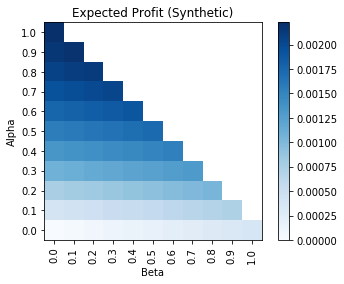

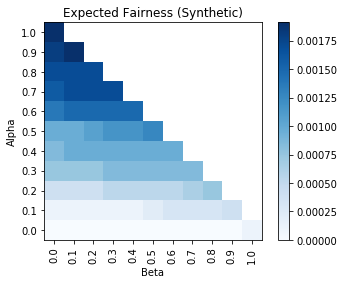

In [49]:
plot_heatmaps([expected_profit_map], x_labels=[str("{:.1f}".format(x)) for x in betas], 
              y_labels=[str("{:.1f}".format(x)) for x in alphas[::-1]], x_title='Beta', y_title='Alpha', 
              subplot_titles=['Expected Profit (Synthetic)'], subfolder='plots', 
              filename='heatmap_expected_profit_synthetic_{}'.format(filename_append))
plot_heatmaps([expected_fairness_map], x_labels=[str("{:.1f}".format(x)) for x in betas], 
              y_labels=[str("{:.1f}".format(x)) for x in alphas[::-1]], x_title='Beta', y_title='Alpha', 
              subplot_titles=['Expected Fairness (Synthetic)'], subfolder='plots', 
              filename='heatmap_expected_fairness_synthetic_{}'.format(filename_append))